In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print(f"XGBoost version: {xgb.__version__}")

XGBoost version: 3.0.2


In [21]:
# Load processed data
train_data = pd.read_csv('../data/processed/train_data.csv')
test_data = pd.read_csv('../data/processed/test_data.csv')

X_train = train_data.drop('Churn', axis=1)
y_train = train_data['Churn']
X_test = test_data.drop('Churn', axis=1)
y_test = test_data['Churn']

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set churn rate: {y_train.mean():.1%}")

Training set shape: (5634, 20)
Test set shape: (1409, 20)
Training set churn rate: 26.5%


In [22]:
# Train basic XGBoost
xgb_basic = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

xgb_basic.fit(X_train, y_train)

xgb_pred = xgb_basic.predict(X_test)
xgb_pred_proba = xgb_basic.predict_proba(X_test)[:, 1]

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

print(f"Accuracy: {xgb_accuracy:.3f}")
print(f"ROC-AUC: {xgb_auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

Accuracy: 0.795
ROC-AUC: 0.834

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409



In [23]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

xgb_tuned = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    xgb_tuned, 
    param_grid, 
    cv=3, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Use subset for faster tuning
sample_size = min(3000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)

grid_search.fit(X_train.iloc[sample_idx], y_train.iloc[sample_idx])

print("Best parameters:")
print(grid_search.best_params_)
print(f"Best CV ROC-AUC: {grid_search.best_score_:.3f}")

# Train final model with best parameters
xgb_final = xgb.XGBClassifier(**grid_search.best_params_, random_state=42, eval_metric='logloss')
xgb_final.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best CV ROC-AUC: 0.848


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
# Model comparison
models = {}

# Load existing models
try:
    models['Logistic Regression'] = joblib.load('../models/logistic_regression.pkl')
    models['Random Forest'] = joblib.load('../models/random_forest.pkl')
except FileNotFoundError:
    print("Some models not found. Train them first.")

models['XGBoost (Basic)'] = xgb_basic
models['XGBoost (Tuned)'] = xgb_final

# Evaluate all models
results = {}

for name, model in models.items():
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'accuracy': accuracy_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, pred_proba),
        'predictions': pred,
        'probabilities': pred_proba
    }

# Display results
print("MODEL COMPARISON:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"   Accuracy: {metrics['accuracy']:.3f}")
    print(f"   ROC-AUC:  {metrics['roc_auc']:.3f}")
    print()

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc'])
print(f"Best Model: {best_model_name}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.3f}")

MODEL COMPARISON:
Logistic Regression:
   Accuracy: 0.806
   ROC-AUC:  0.846

Random Forest:
   Accuracy: 0.783
   ROC-AUC:  0.823

XGBoost (Basic):
   Accuracy: 0.795
   ROC-AUC:  0.834

XGBoost (Tuned):
   Accuracy: 0.805
   ROC-AUC:  0.848

Best Model: XGBoost (Tuned)
ROC-AUC: 0.848


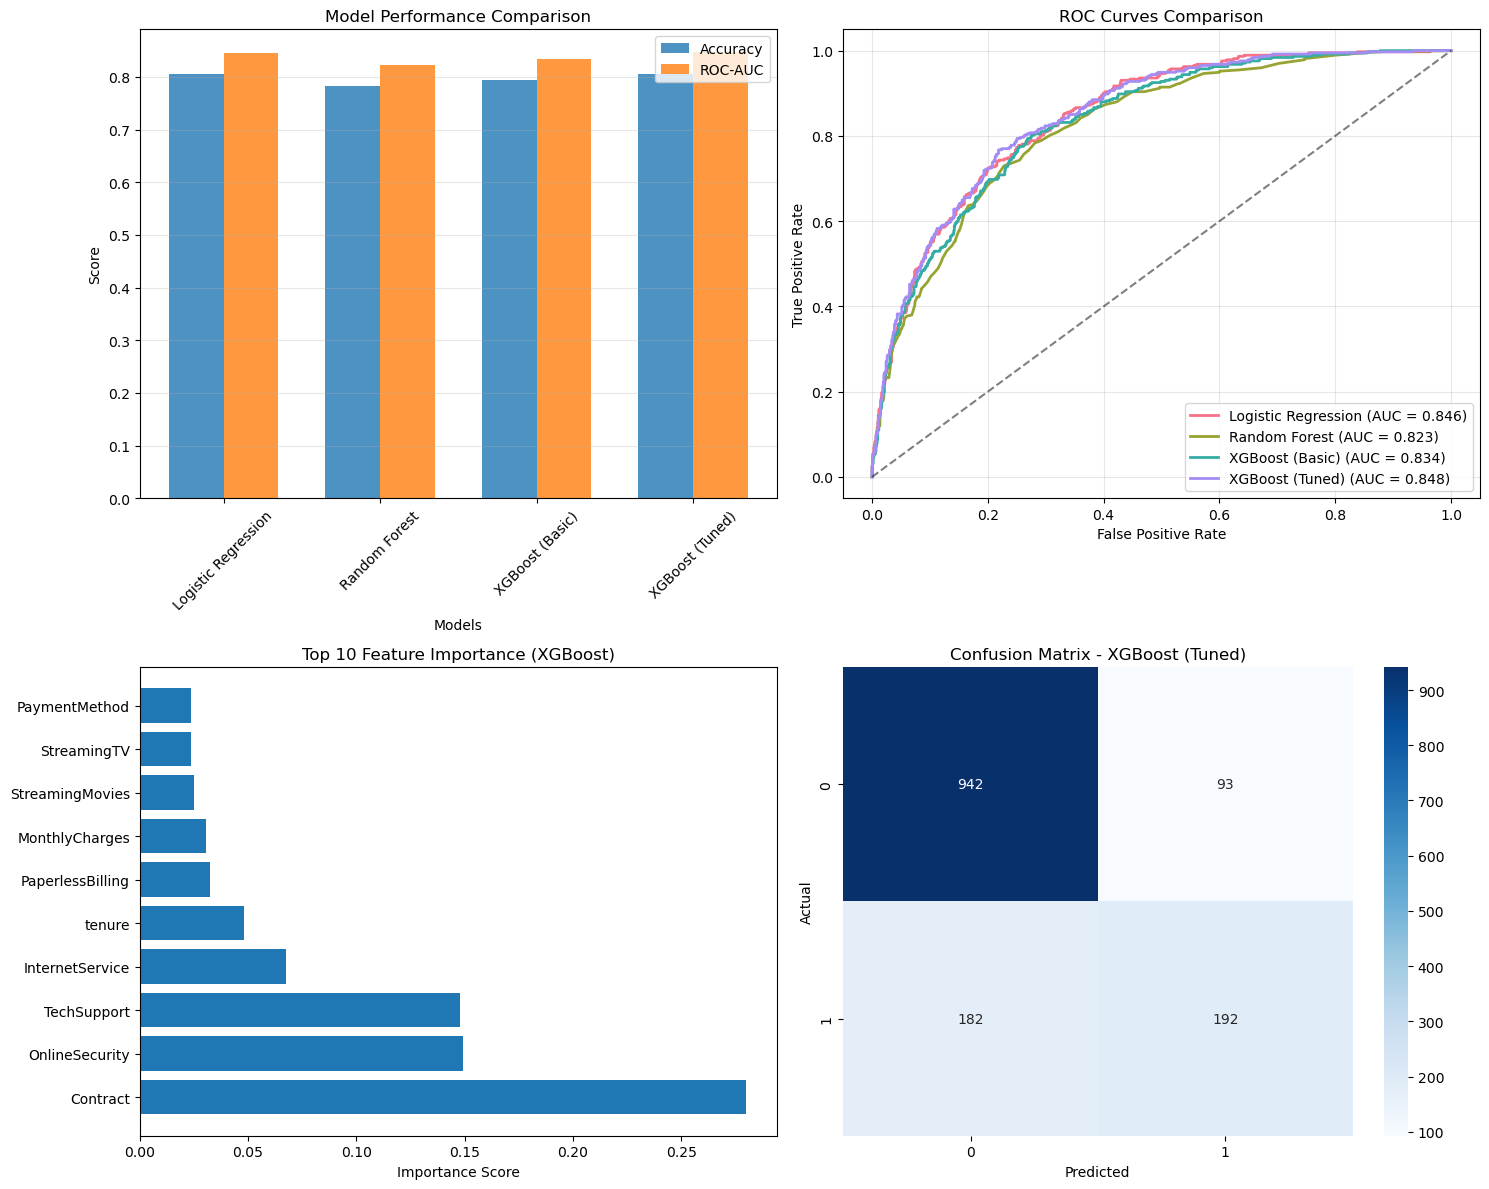

In [25]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Model comparison bar chart
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
aucs = [results[name]['roc_auc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0,0].bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
axes[0,0].bar(x + width/2, aucs, width, label='ROC-AUC', alpha=0.8)
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xlabel('Models')
axes[0,0].set_ylabel('Score')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(model_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(axis='y', alpha=0.3)

# ROC Curves
for i, (name, metrics) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, metrics['probabilities'])
    auc = metrics['roc_auc']
    color = sns.color_palette("husl", len(results))[i]
    axes[0,1].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2, color=color)

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_title('ROC Curves Comparison')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Feature Importance (XGBoost)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[1,0].set_title('Top 10 Feature Importance (XGBoost)')
axes[1,0].set_xlabel('Importance Score')

# Confusion Matrix (Best Model)
best_pred = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
axes[1,1].set_title(f'Confusion Matrix - {best_model_name}')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [26]:
# Save models and results
joblib.dump(xgb_final, '../models/xgboost.pkl')
joblib.dump(results, '../models/model_comparison_results.pkl')

# Create model summary
model_summary = {
    'best_model': best_model_name,
    'best_auc': results[best_model_name]['roc_auc'],
    'best_accuracy': results[best_model_name]['accuracy'],
    'all_results': {name: {'accuracy': metrics['accuracy'], 'roc_auc': metrics['roc_auc']} 
                   for name, metrics in results.items()},
    'feature_importance': feature_importance.to_dict('records')
}

joblib.dump(model_summary, '../models/model_summary.pkl')

print("Models trained and saved successfully!")
print(f"Best performing model: {best_model_name}")
print(f"Final ROC-AUC Score: {results[best_model_name]['roc_auc']:.3f}")

Models trained and saved successfully!
Best performing model: XGBoost (Tuned)
Final ROC-AUC Score: 0.848
